### Baseline

threshold on the dnbr? 

In [28]:
import rasterio as rio
from rasterio.fill import fillnodata
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import inpaint
from scipy import ndimage


In [29]:
in_file = 'KENNETH_20250109.tif'
out_file = 'KENNETH_20250109_interpolated.tif'

In [34]:
with rio.open(in_file) as img:
    data = img.read().astype(np.float32)
    profile = img.profile
    data[data == img.nodata] = np.nan


mask_3d = np.isnan(data)    # True is nan
mask_2d = np.any(mask_3d, axis=0)  # if any band is nan, pixel is invalid
filled_data = np.zeros_like(data)

for idx in range(data.shape[0]):
    band = data[idx,:, :].copy()
    indices = ndimage.distance_transform_edt(mask_2d, return_distances=False, return_indices=True)
    filled_data[idx, :, :] = band[tuple(indices)]

profile.update(dtype=rio.float32, nodata=np.nan)

with rio.open(out_file, 'w', **profile) as out:
    out.write(filled_data)

SENTINEL-2 data are acquired on 13 spectral bands in the visible and near-infrared (VNIR) and Short-wavelength infrared (SWIR) spectrum, as show in the below table:

| Band name | Resolution (m) | Central wavelength (nm) | Band width (nm) | Purpose |
|-----------|----------------|-------------------------|-----------------|---------|
|B02|10|490|65|Blue|
|B03|10|560|35|Green|
|B04|10|665|30|Red|
|B08|10|842|115|Near infrared|
|B12|20|2190|180|Snow / ice / cloud discrimination|


Bands in the Tiff data are 'B2', 'B3', 'B4', 'B8', 'B12'

In [31]:
data.shape
filled_data.shape

(5, 206, 239)

In [35]:
np.isnan(filled_data)

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

In [36]:
with rio.open(out_file) as f:
    bands = f.read()
    for i in range(5):
        print(f"Max in band {i}: {np.max(bands[i])}, Min in band {i}: {np.min(bands[i])}")

Max in band 0: 5040.0, Min in band 0: 57.0
Max in band 1: 5124.0, Min in band 1: 90.0
Max in band 2: 5328.0, Min in band 2: 88.0
Max in band 3: 6194.0, Min in band 3: 392.0
Max in band 4: 4787.0, Min in band 4: 398.0


In [38]:
# Scale the value to range [0, 255]
for i in range(5):
    bands[i] *= (255.0 / np.max(bands[i])) 
    print(f"Max in band {i}: {np.max(bands[i])}, Min in band {i}: {np.min(bands[i])}")


Max in band 0: 255.0, Min in band 0: 2.8839285373687744
Max in band 1: 255.0, Min in band 1: 4.478922367095947
Max in band 2: 255.0, Min in band 2: 4.211711883544922
Max in band 3: 255.0, Min in band 3: 16.138198852539062
Max in band 4: 255.0, Min in band 4: 21.201169967651367


In [45]:
mask_file = r"KENNETH_20250109_mask.tif"

In [46]:
with rio.open(mask_file) as m:
    mask = m.read()

In [47]:
mask.shape

(1, 206, 239)

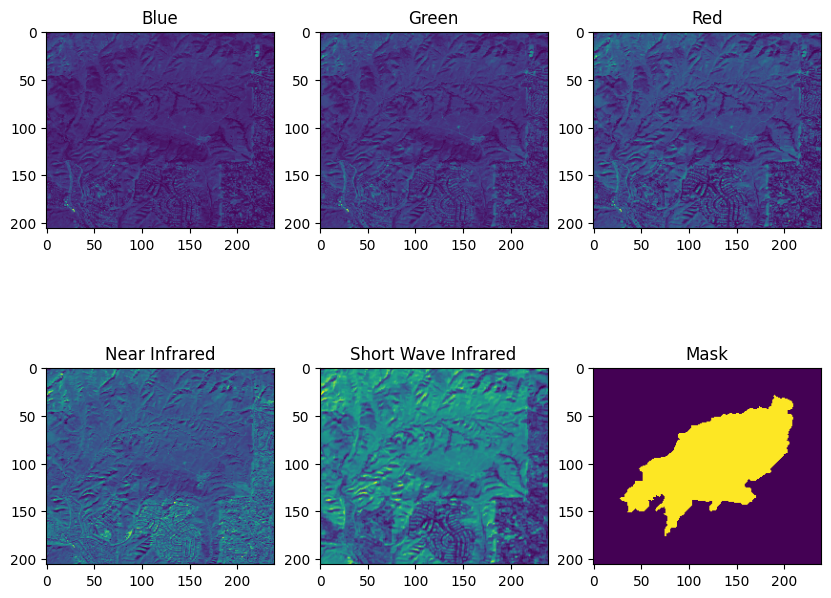

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(10, 8))
ax[0, 0].imshow(bands[0], )
ax[0, 0].set_title("Blue")
ax[0, 1].imshow(bands[1])
ax[0, 1].set_title("Green")
ax[0, 2].imshow(bands[2])
ax[0, 2].set_title("Red")
ax[1, 0].imshow(bands[3])
ax[1, 0].set_title("Near Infrared")
ax[1, 1].imshow(bands[4])
ax[1, 1].set_title("Short Wave Infrared")
ax[1, 2].imshow(mask[0])
ax[1, 2].set_title("Mask")    # 0 is the background
plt.show()

In [2]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import numpy as np

#### Process dataset

In [40]:
img_dir = r'../data/post_fire'
mask_dir = r'../data/masks'
dnbr_dire = r'../data/dnbr'

In [ ]:
class FireDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, mask_dir, img_list):
        self.img_dir = img_dir
        self.mask_dir = mask_dir   # 0, 1 unburned or burned
        self.img_list = img_list
    
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self):
        file_name = self.img_list[idx]
        img_path = os.path.join(self.img_dir, file_name)
        mask_path = os.path.join(self.mask_dir, os.path.exists(file_name)[0] + 'tif')

        img = self.fillnan(img_path)
        mask = rio.open(mask_path)

        img_tensor = transforms.ToTensor()(img)
        img_tensor = transforms.Normalize(
            mean = [0.485, 0.456, 0.406], 
            std = [0.229, 0.224, 0.225]
        )(img_tensor)

        mask_tensor = transforms.ToTensor()(mask).long().squeeze()
        return img_tensor, mask_tensor


    def fillnan(self, in_file):
        with rio.open(in_file) as img:
            data = img.read().astype(np.float32)
            profile = img.profile
            data[data == img.nodata] = np.nan

        mask_3d = np.isnan(data)    # True is nan
        mask_2d = np.any(mask_3d, axis=0)  # if any band is nan, pixel is invalid
        filled_data = np.zeros_like(data)

        for idx in range(data.shape[0]):
            band = data[idx,:, :].copy()
            indices = ndimage.distance_transform_edt(mask_2d, return_distances=False, return_indices=True)
            filled_data[idx, :, :] = band[tuple(indices)]
            filled_data[idx] *= (255.0 / np.max(filled_data[idx])) 
        
        return filled_data

    

#### Implement a simple U-Net

* split the dataset, avoid the leakage (spatially)
* considering the image resolution
* different image size for each event

#### U-Net variants

In [ ]:
class UNet:
    def __init__(self, in_features, out_features, ):
        self.in_features = in_features
        self.out_features = out_features

    def forward(self, x):
        pass

    def upsample(self, x):
        pass

